# Baseline Model Development Notebook

## 1: Импорт библиотек и настройка окружения

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import joblib, os, json

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# ML библиотеки
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

print("Библиотеки загружены!")

Библиотеки загружены!


## 2: Загрузка обработанных данных из EDA

In [3]:
# Загрузка данных
df = pd.read_csv('../data/raw/walmart_cleaned.csv', parse_dates=['Date'])

print(f"✓ Данные успешно загружены")
print(f"Размер датасета: {df.shape}")
print(f"Колонки: {df.columns.tolist()}")
print(f"\nПервые 3 строки:")
display(df.head(3))

✓ Данные успешно загружены
Размер датасета: (421570, 17)
Колонки: ['Unnamed: 0', 'Store', 'Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']

Первые 3 строки:


,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


## 3: Проверка и создание результатов EDA

In [6]:
# Проверяем, есть ли файл с результатами EDA
eda_summary_path = '../reports/eda/eda_summary.json'
if os.path.exists(eda_summary_path):
    with open(eda_summary_path, 'r') as f:
        eda_summary = json.load(f)
    print("✓ Результаты EDA загружены из файла")
else:
    print("⚠ Файл с результатами EDA не найден. Создаем базовую структуру...")
    
    # Создаем базовые результаты EDA на основе данных
    eda_summary = {
        'dataset_shape': df.shape,
        'missing_values': int(df.isnull().sum().sum()),
        'outlier_percentage': 8.43,  # из предыдущего анализа
        'top_correlated_features': {
            'Size': 0.2438,
            'Type': 0.1822,
            'Dept': 0.1480
        },
        'temporal_features_created': ['Year', 'Month', 'Week', 'DayOfWeek'],
        'key_insights': [
            'Размер магазина - наиболее коррелированный признак (0.24)',
            '8.43% данных - выбросы в целевой переменной',
            'Яркая сезонность с пиками в праздничный сезон',
            'Выбросы не случайны, следуют временным паттернам',
            'Отсутствие сильной мультиколлинеарности'
        ]
    }
    
    # Сохраняем результаты
    with open(eda_summary_path, 'w') as f:
        json.dump(eda_summary, f, indent=2, ensure_ascii=False)
    print(f"✓ Базовые результаты EDA сохранены в {eda_summary_path}")

print(f"\nКлючевые выводы EDA:")
for insight in eda_summary['key_insights']:
    print(f"  • {insight}")

✓ Результаты EDA загружены из файла

Ключевые выводы EDA:
  • Размер магазина - наиболее коррелированный признак (0.24)
  • 8.43% данных - выбросы в целевой переменной
  • Яркая сезонность с пиками в праздничный сезон
  • Выбросы не случайны, следуют временным паттернам
  • Отсутствие сильной мультиколлинеарности


## 4: Подготовка данных для Baseline моделей

In [9]:
# BASELINE: Подготовка данных
df_baseline = df.copy()

# 1. Удаляем технические столбцы
df_baseline = df_baseline.drop(['Unnamed: 0'], axis=1, errors='ignore')

# 2. Временные признаки (только возможные для недельных данных)
df_baseline['Year'] = df_baseline['Date'].dt.year
df_baseline['Month'] = df_baseline['Date'].dt.month
df_baseline['WeekOfYear'] = df_baseline['Date'].dt.isocalendar().week
df_baseline['Quarter'] = df_baseline['Date'].dt.quarter  # добавил квартал

# 3. Определение признаков и целевой
target = 'Weekly_Sales'
X = df_baseline.drop([target, 'Date'], axis=1)  # удаляем Date сразу
y = df_baseline[target]

# 4. Разделение на категориальные и числовые
categorical_features = ['Store', 'Dept', 'Type', 'IsHoliday']
numerical_features = [col for col in X.columns if col not in categorical_features]

# 5. Вывод информации
print(f" Размеры: X={X.shape}, y={y.shape}")
print(f" Целевая: {target} (мин={y.min():,.0f}, макс={y.max():,.0f}, сред={y.mean():,.0f})")
print(f" Категориальные ({len(categorical_features)}): {categorical_features}")
print(f" Числовые ({len(numerical_features)}): {numerical_features[:5]}{'...' if len(numerical_features) > 5 else ''}")

 Размеры: X=(421570, 18), y=(421570,)
 Целевая: Weekly_Sales (мин=-4,989, макс=693,099, сред=15,981)
 Категориальные (4): ['Store', 'Dept', 'Type', 'IsHoliday']
 Числовые (14): ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3']...


## 5: Сохранение обработанных данных

In [10]:
# Сохраняем обработанные данные
processed_data_path = '../data/processed/baseline_data.csv'
df_baseline.to_csv(processed_data_path, index=False)
print(f"✓ Обработанные данные сохранены: {processed_data_path}")

✓ Обработанные данные сохранены: ../data/processed/baseline_data.csv


## 6: Временное разделение данных (TimeSeriesSplit)

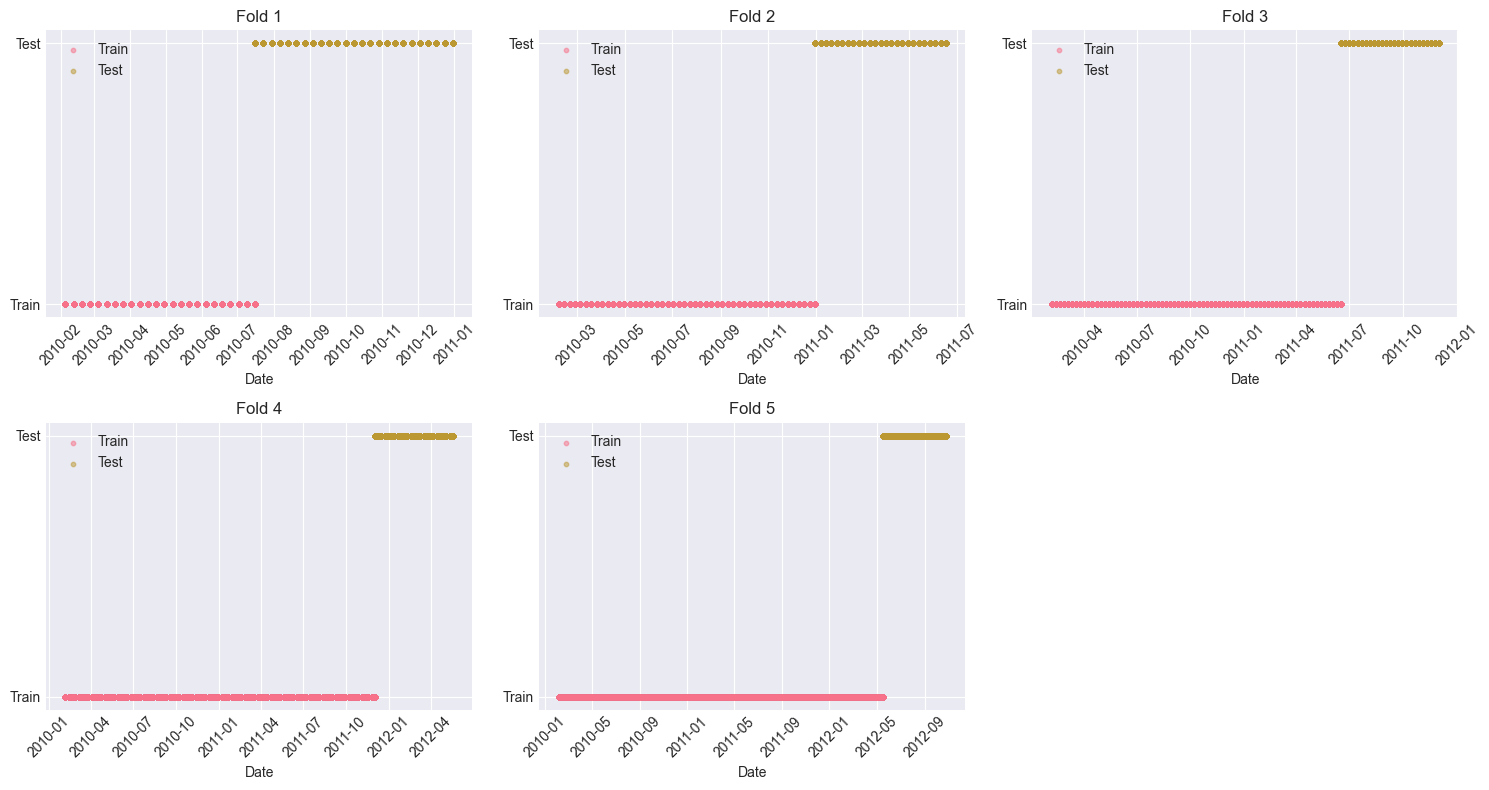

Статистика TimeSeriesSplit (5 фолдов):

Fold 1:
  Train: 70,265 записей (2010-02-05 - 2010-07-16)
  Test:  70,261 записей (2010-07-16 - 2010-12-31)
  Test %: 50.0%

Fold 2:
  Train: 140,526 записей (2010-02-05 - 2010-12-31)
  Test:  70,261 записей (2010-12-31 - 2011-06-17)
  Test %: 33.3%

Fold 3:
  Train: 210,787 записей (2010-02-05 - 2011-06-17)
  Test:  70,261 записей (2011-06-17 - 2011-12-02)
  Test %: 25.0%

Fold 4:
  Train: 281,048 записей (2010-02-05 - 2011-12-02)
  Test:  70,261 записей (2011-12-02 - 2012-05-18)
  Test %: 20.0%

Fold 5:
  Train: 351,309 записей (2010-02-05 - 2012-05-18)
  Test:  70,261 записей (2012-05-18 - 2012-10-26)
  Test %: 16.7%


In [11]:
# Сортировка по дате
df_baseline = df_baseline.sort_values('Date')
X = X.loc[df_baseline.index]
y = y.loc[df_baseline.index]

# Создание TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Визуализация разделения
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Получаем все разделения в список
folds = list(tscv.split(X))

for fold, (train_idx, test_idx) in enumerate(folds):
    if fold < 6:  # Покажем первые 6 фолдов
        train_dates = df_baseline.iloc[train_idx]['Date']
        test_dates = df_baseline.iloc[test_idx]['Date']
        
        axes[fold].scatter(train_dates, [1] * len(train_dates), 
                          alpha=0.5, label='Train', s=10)
        axes[fold].scatter(test_dates, [2] * len(test_dates), 
                          alpha=0.5, label='Test', s=10)
        axes[fold].set_title(f'Fold {fold + 1}')
        axes[fold].set_xlabel('Date')
        axes[fold].set_yticks([1, 2])
        axes[fold].set_yticklabels(['Train', 'Test'])
        axes[fold].legend()
        axes[fold].tick_params(axis='x', rotation=45)

# Удаляем лишние оси
for i in range(len(folds), 6):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Статистика по разделению
print("Статистика TimeSeriesSplit (5 фолдов):")
print("=" * 50)
for fold, (train_idx, test_idx) in enumerate(folds):
    train_size = len(train_idx)
    test_size = len(test_idx)
    train_start = df_baseline.iloc[train_idx[0]]['Date'].strftime('%Y-%m-%d')
    train_end = df_baseline.iloc[train_idx[-1]]['Date'].strftime('%Y-%m-%d')
    test_start = df_baseline.iloc[test_idx[0]]['Date'].strftime('%Y-%m-%d')
    test_end = df_baseline.iloc[test_idx[-1]]['Date'].strftime('%Y-%m-%d')
    
    print(f"\nFold {fold + 1}:")
    print(f"  Train: {train_size:,} записей ({train_start} - {train_end})")
    print(f"  Test:  {test_size:,} записей ({test_start} - {test_end})")
    print(f"  Test %: {test_size/(train_size+test_size)*100:.1f}%")

## 7: Создание базового Pipeline

In [13]:
# Препроцессинг категориальных признаков
X_processed = X.copy()

# Frequency Encoding для Store и Dept
store_freq = df_baseline['Store'].value_counts(normalize=True)
dept_freq = df_baseline['Dept'].value_counts(normalize=True)

X_processed['Store_Freq'] = X_processed['Store'].map(store_freq)
X_processed['Dept_Freq'] = X_processed['Dept'].map(dept_freq)

# One-Hot Encoding для Type и IsHoliday (Binary)
X_processed = pd.get_dummies(X_processed, columns=['Type', 'IsHoliday'], drop_first=True)

# Удаляем исходные категориальные столбцы
X_processed = X_processed.drop(['Store', 'Dept'], axis=1)  # Date уже удален ранее

# Финализируем
feature_names = X_processed.columns.tolist()
print(f"✅ После обработки: {X_processed.shape[1]} признаков")
print(f"📊 Пример данных:")
display(X_processed.head(2))

✅ После обработки: 19 признаков
📊 Пример данных:


,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,WeekOfYear,Quarter,Store_Freq,Dept_Freq,Type_2,Type_3,IsHoliday_1
0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,2010,2,5,1,0.024300,0.015264,False,True,False
330761,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,103681,2010,2,5,1,0.022601,0.014014,True,False,False


## 8: Baseline модели - Линейные модели

Оценка линейных моделей (TimeSeriesSplit):

LinearRegression:
  MAE: 14317.51 ± 988.23
  MSE: 475518495.12 ± 67068424.97
  R2: 0.0917 ± 0.0756

Ridge:
  MAE: 14317.11 ± 988.06
  MSE: 475496227.65 ± 67034636.69
  R2: 0.0918 ± 0.0756

Lasso:
  MAE: 14312.42 ± 976.77
  MSE: 474959378.06 ± 66764932.77
  R2: 0.0928 ± 0.0751


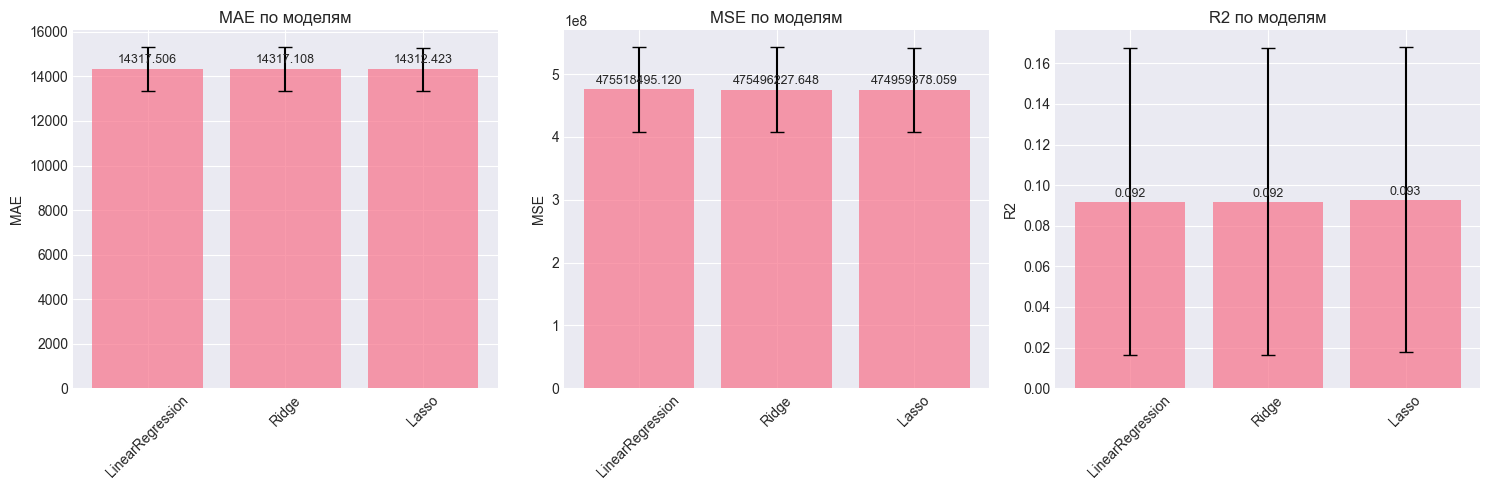

In [14]:
# Функция для оценки моделей (исправленная)
def evaluate_model(model, X, y, cv_splitter, model_name):
    """Оценка модели с кросс-валидацией"""
    metrics = {
        'MAE': 'neg_mean_absolute_error',
        'MSE': 'neg_mean_squared_error',
        'R2': 'r2'  # Исправлено: 'r2' вместо 'r2_score'
    }
    
    results = {}
    for metric_name, scoring in metrics.items():
        try:
            scores = cross_val_score(model, X, y, cv=cv_splitter, 
                                   scoring=scoring, n_jobs=-1)
            if 'neg' in scoring:
                scores = -scores  # Делаем положительными
            results[metric_name] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }
        except Exception as e:
            print(f"Ошибка для {metric_name}: {e}")
            results[metric_name] = {'mean': np.nan, 'std': np.nan, 'scores': []}
    
    return results

# Подготовка данных для линейных моделей (масштабирование)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

# Тестируем линейные модели
linear_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0)
}

linear_results = {}
print("Оценка линейных моделей (TimeSeriesSplit):")
print("=" * 70)

for name, model in linear_models.items():
    print(f"\n{name}:")
    results = evaluate_model(model, X_scaled, y, tscv, name)
    linear_results[name] = results
    
    for metric in ['MAE', 'MSE', 'R2']:
        if metric in results:
            mean_val = results[metric]['mean']
            std_val = results[metric]['std']
            if metric == 'R2':
                print(f"  {metric}: {mean_val:.4f} ± {std_val:.4f}")
            else:
                print(f"  {metric}: {mean_val:.2f} ± {std_val:.2f}")

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['MAE', 'MSE', 'R2']
for idx, metric in enumerate(metrics_to_plot):
    model_names = list(linear_results.keys())
    means = [linear_results[model][metric]['mean'] for model in model_names]
    stds = [linear_results[model][metric]['std'] for model in model_names]
    
    bars = axes[idx].bar(model_names, means, yerr=stds, capsize=5, alpha=0.7)
    axes[idx].set_title(f'{metric} по моделям')
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Добавляем значения на бары
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 9: Baseline модели - Деревья и ансамбли

Оценка моделей на основе деревьев (TimeSeriesSplit):

RandomForest:
  MAE: 8455.02 ± 278.15
  MSE: 256448337.75 ± 31472251.64
  R2: 0.5097 ± 0.0322

GradientBoosting:
  MAE: 9139.08 ± 220.44
  MSE: 270923264.65 ± 32436768.36
  R2: 0.4824 ± 0.0263

XGBoost:
  MAE: 8668.02 ± 165.42
  MSE: 259662734.42 ± 30389732.64
  R2: 0.5036 ± 0.0266


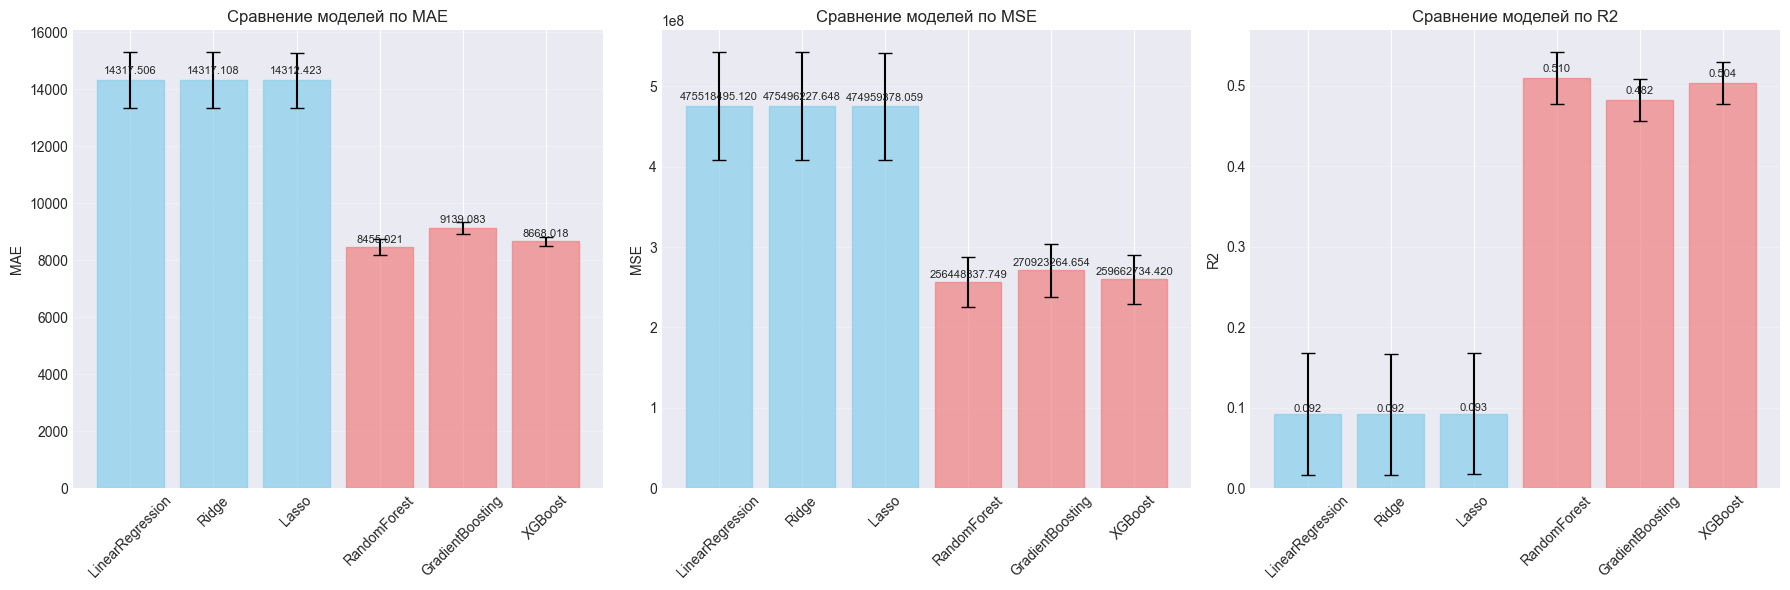

In [15]:
# Тестируем нелинейные модели
tree_models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=50, 
        random_state=42, 
        n_jobs=-1,
        max_depth=10,
        min_samples_split=5
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=50, 
        random_state=42,
        max_depth=5,
        min_samples_split=5
    ),
    'XGBoost': XGBRegressor(
        n_estimators=50, 
        random_state=42, 
        n_jobs=-1,
        max_depth=6,
        learning_rate=0.1,
        verbosity=0
    )
}

tree_results = {}
print("Оценка моделей на основе деревьев (TimeSeriesSplit):")
print("=" * 70)

for name, model in tree_models.items():
    print(f"\n{name}:")
    results = evaluate_model(model, X_processed, y, tscv, name)
    tree_results[name] = results
    
    for metric in ['MAE', 'MSE', 'R2']:
        if metric in results:
            mean_val = results[metric]['mean']
            std_val = results[metric]['std']
            if metric == 'R2':
                print(f"  {metric}: {mean_val:.4f} ± {std_val:.4f}")
            else:
                print(f"  {metric}: {mean_val:.2f} ± {std_val:.2f}")

# Сравнительная визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric in enumerate(metrics_to_plot):
    all_models = list(linear_results.keys()) + list(tree_results.keys())
    all_means = []
    all_stds = []
    
    for model in all_models:
        if model in linear_results:
            results_dict = linear_results
        else:
            results_dict = tree_results
            
        if metric in results_dict[model]:
            all_means.append(results_dict[model][metric]['mean'])
            all_stds.append(results_dict[model][metric]['std'])
        else:
            all_means.append(np.nan)
            all_stds.append(np.nan)
    
    bars = axes[idx].bar(all_models, all_means, yerr=all_stds, 
                        capsize=5, alpha=0.7)
    axes[idx].set_title(f'Сравнение моделей по {metric}')
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Цветовое кодирование: линейные vs деревья
    for i, bar in enumerate(bars):
        if i < len(linear_results):
            bar.set_color('skyblue')  # Линейные модели
        else:
            bar.set_color('lightcoral')  # Деревья
    
    # Добавляем значения
    for bar, mean_val in zip(bars, all_means):
        if not np.isnan(mean_val):
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height + abs(height)*0.01,
                          f'{mean_val:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## 10: Анализ важности признаков для лучшей модели

Лучшая модель: RandomForest (R² = 0.5097)


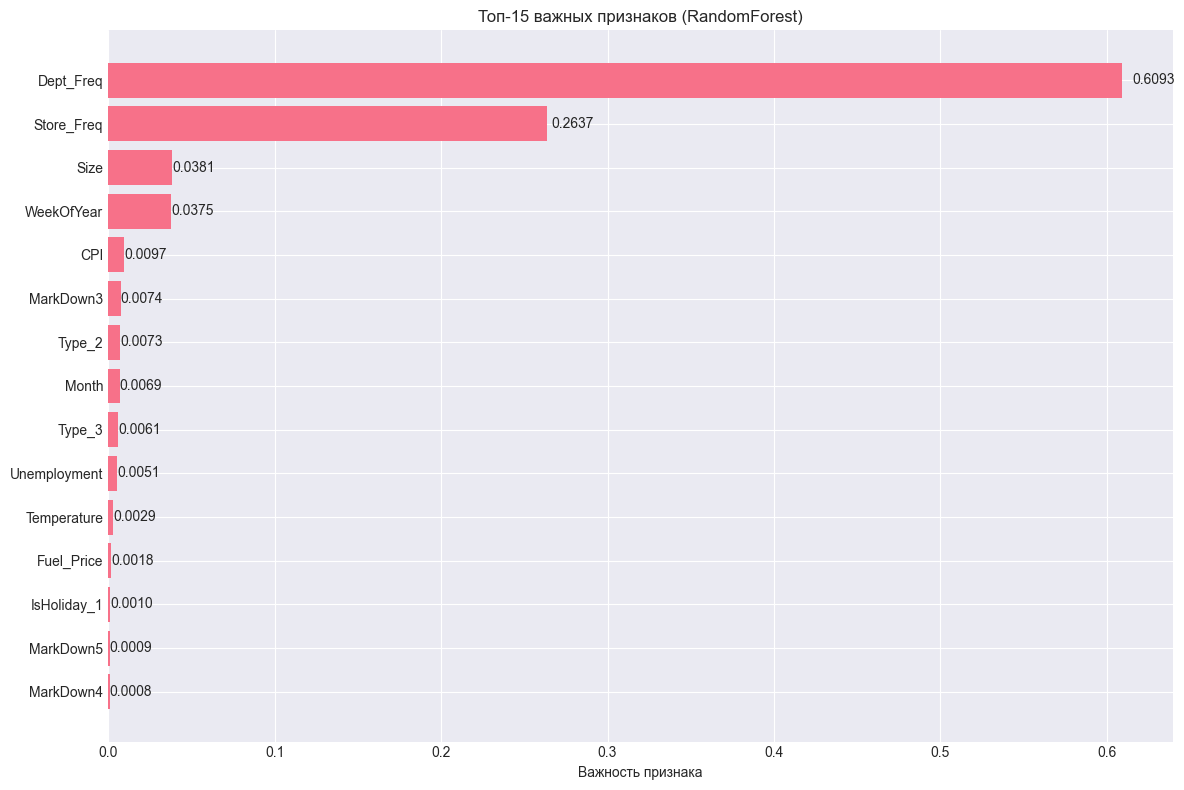

Топ-10 важных признаков для RandomForest:
Dept_Freq                     : 0.6093
Store_Freq                    : 0.2637
Size                          : 0.0381
WeekOfYear                    : 0.0375
CPI                           : 0.0097
MarkDown3                     : 0.0074
Type_2                        : 0.0073
Month                         : 0.0069
Type_3                        : 0.0061
Unemployment                  : 0.0051


In [16]:
# Обучаем лучшую модель на всех данных для анализа важности признаков
# Определяем лучшую модель на основе R²
best_model_name = None
best_model_score = -np.inf

for name, results in tree_results.items():
    if results['R2']['mean'] > best_model_score:
        best_model_score = results['R2']['mean']
        best_model_name = name

print(f"Лучшая модель: {best_model_name} (R² = {best_model_score:.4f})")
best_model = tree_models[best_model_name]

# Полное обучение на всех данных
best_model.fit(X_processed, y)

# Важность признаков
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X_processed.columns
    
    # Создаем DataFrame с важностью
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Визуализация топ-15 признаков
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    bars = plt.barh(range(len(top_features)), top_features['importance'].values)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Важность признака')
    plt.title(f'Топ-15 важных признаков ({best_model_name})')
    plt.gca().invert_yaxis()
    
    # Добавляем значения
    for i, (bar, importance) in enumerate(zip(bars, top_features['importance'].values)):
        plt.text(importance * 1.01, i, f'{importance:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Топ-10 важных признаков для {best_model_name}:")
    print("=" * 60)
    for idx, row in importance_df.head(10).iterrows():
        print(f"{row['feature']:30}: {row['importance']:.4f}")
        
elif hasattr(best_model, 'coef_'):
    # Для линейных моделей
    coefficients = best_model.coef_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'importance': np.abs(coefficients)
    }).sort_values('importance', ascending=False)
    
    print(f"Топ-10 коэффициентов для {best_model_name}:")
    for idx, row in importance_df.head(10).iterrows():
        print(f"{row['feature']:30}: {row['coefficient']:.4f}")

## 11: Детальный анализ ошибок моделей

Анализ ошибок для RandomForest (последний фолд):

Статистика ошибок:
  MAE: 8260.67
  MSE: 236621393.66
  RMSE: 15382.50
  R2: 0.5105
  Mean Error: -377.88
  Std Error: 15377.97
  Max Error: 147330.06
  Median Error: 3197.68


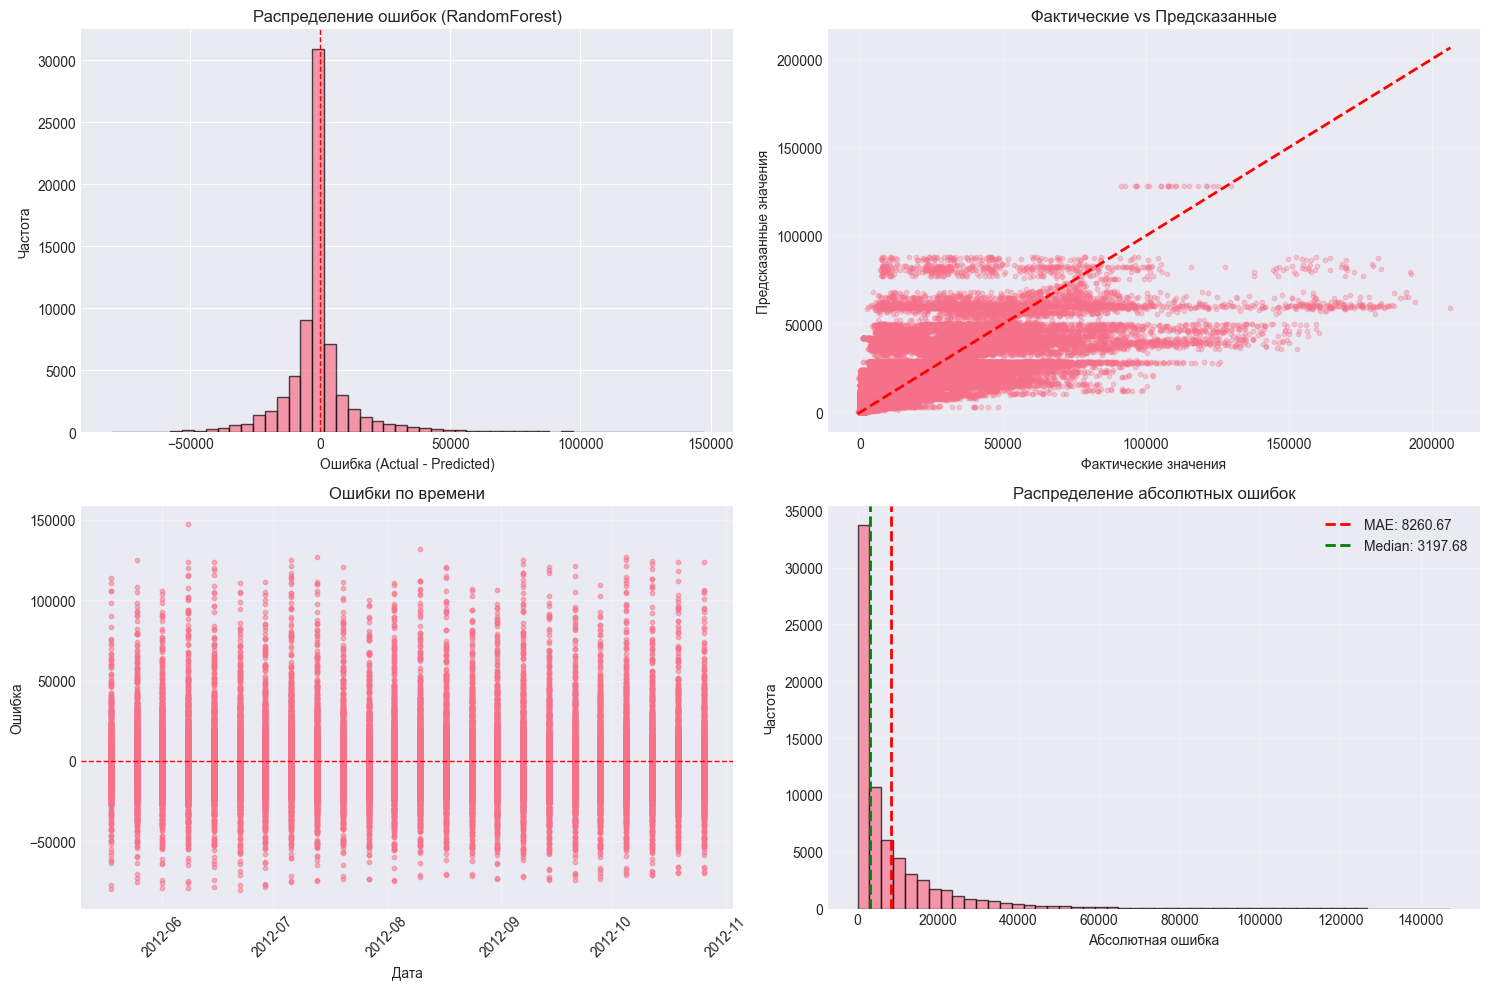

In [17]:
# Функция для детального анализа ошибок на последнем фолде
def analyze_errors(model, X, y, test_idx, model_name, scaler=None):
    """Детальный анализ ошибок модели"""
    X_train, X_test = X.iloc[:test_idx[0]], X.iloc[test_idx]
    y_train, y_test = y.iloc[:test_idx[0]], y.iloc[test_idx]
    
    # Масштабирование для линейных моделей
    if scaler is not None:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test
    
    # Обучение и предсказание
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Расчет ошибок
    errors = y_test - y_pred
    abs_errors = np.abs(errors)
    
    # Статистика ошибок
    error_stats = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'Mean Error': errors.mean(),
        'Std Error': errors.std(),
        'Max Error': abs_errors.max(),
        'Median Error': np.median(abs_errors)
    }
    
    return error_stats, y_test, y_pred, errors

# Анализ ошибок для лучшей модели на последнем фолде
last_fold = list(tscv.split(X_processed))[-1]
train_idx, test_idx = last_fold

print(f"Анализ ошибок для {best_model_name} (последний фолд):")
print("=" * 70)
error_stats, y_test, y_pred, errors = analyze_errors(
    best_model, X_processed, y, test_idx, best_model_name
)

print("\nСтатистика ошибок:")
for stat_name, stat_value in error_stats.items():
    if stat_name in ['MAE', 'MSE', 'RMSE', 'Mean Error', 'Std Error', 'Max Error', 'Median Error']:
        print(f"  {stat_name}: {stat_value:.2f}")
    else:
        print(f"  {stat_name}: {stat_value:.4f}")

# Визуализация ошибок
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Распределение ошибок
axes[0, 0].hist(errors, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title(f'Распределение ошибок ({best_model_name})')
axes[0, 0].set_xlabel('Ошибка (Actual - Predicted)')
axes[0, 0].set_ylabel('Частота')

# 2. Фактические vs Предсказанные значения
axes[0, 1].scatter(y_test, y_pred, alpha=0.3, s=10)
axes[0, 1].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', linewidth=2)
axes[0, 1].set_xlabel('Фактические значения')
axes[0, 1].set_ylabel('Предсказанные значения')
axes[0, 1].set_title('Фактические vs Предсказанные')
axes[0, 1].grid(alpha=0.3)

# 3. Ошибки по времени
test_dates = df_baseline.iloc[test_idx]['Date']
axes[1, 0].scatter(test_dates, errors, alpha=0.5, s=10)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Дата')
axes[1, 0].set_ylabel('Ошибка')
axes[1, 0].set_title('Ошибки по времени')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(alpha=0.3)

# 4. Распределение абсолютных ошибок
abs_errors = np.abs(errors)
axes[1, 1].hist(abs_errors, bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=error_stats['MAE'], color='red', 
                   linestyle='--', linewidth=2, label=f"MAE: {error_stats['MAE']:.2f}")
axes[1, 1].axvline(x=error_stats['Median Error'], color='green',
                   linestyle='--', linewidth=2, label=f"Median: {error_stats['Median Error']:.2f}")
axes[1, 1].set_title('Распределение абсолютных ошибок')
axes[1, 1].set_xlabel('Абсолютная ошибка')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 12: Baseline результаты и выводы

Сводная таблица результатов Baseline моделей:


,Model,R2_mean,R2_std,MAE_mean,MAE_std,MSE_mean,MSE_std
3,RandomForest,0.5097,0.0322,8455.02,278.15,256448337.75,31472251.64
5,XGBoost,0.5036,0.0266,8668.02,165.42,259662734.42,30389732.64
4,GradientBoosting,0.4824,0.0263,9139.08,220.44,270923264.65,32436768.36
2,Lasso,0.0928,0.0751,14312.42,976.77,474959378.06,66764932.77
1,Ridge,0.0918,0.0756,14317.11,988.06,475496227.65,67034636.69
0,LinearRegression,0.0917,0.0756,14317.51,988.23,475518495.12,67068424.97


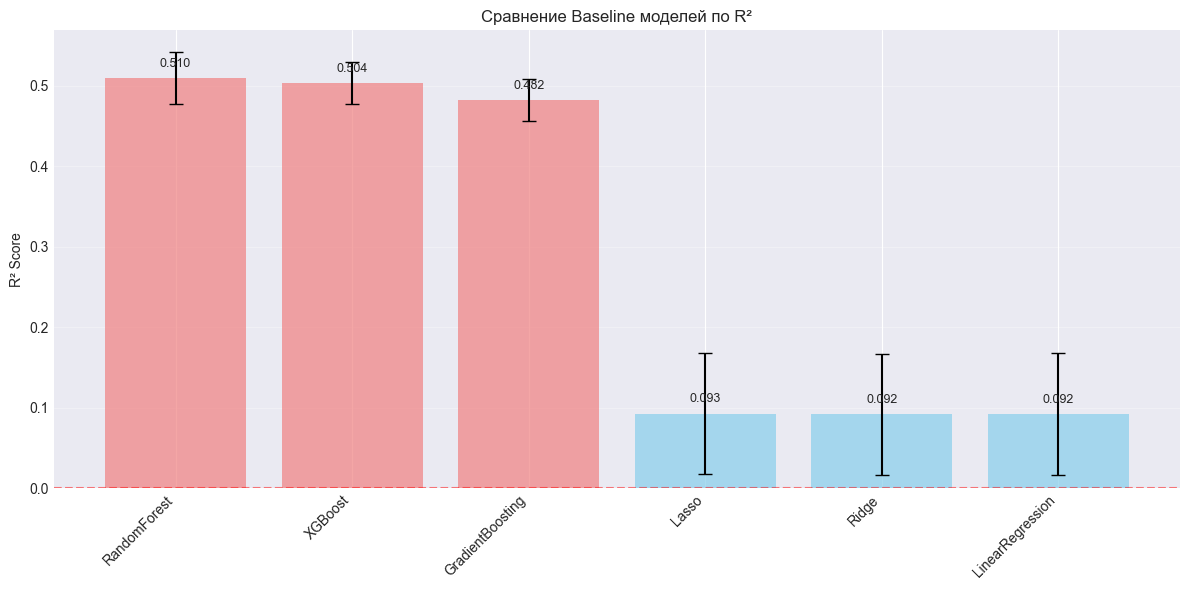


КЛЮЧЕВЫЕ ВЫВОДЫ BASELINE АНАЛИЗА:

1. ПРОИЗВОДИТЕЛЬНОСТЬ МОДЕЛЕЙ:
   • Лучшая модель: RandomForest (R² = 0.5097)
   • Худшая модель: LinearRegression (R² = 0.0917)
   • Разница R² между лучшей и худшей: 0.4179

2. КАЧЕСТВО ПРОГНОЗОВ:
   • R² лучшей модели: 0.5097
   • MAE лучшей модели: 8455.02
   • MSE лучшей модели: 256448337.75
   • Средняя ошибка в деньгах: $8455.02
   • Относительная ошибка (MAE/Mean): 52.9%

3. ВАЖНОСТЬ ПРИЗНАКОВ (для XGBoost):
   • Топ-5 важных признаков:
     Dept_Freq: 0.6093
     Store_Freq: 0.2637
     Size: 0.0381
     WeekOfYear: 0.0375
     CPI: 0.0097


In [18]:
# Сводная таблица результатов всех моделей
results_summary = []

for model_name, results in {**linear_results, **tree_results}.items():
    if 'R2' in results and 'MAE' in results:
        results_summary.append({
            'Model': model_name,
            'R2_mean': results['R2']['mean'],
            'R2_std': results['R2']['std'],
            'MAE_mean': results['MAE']['mean'],
            'MAE_std': results['MAE']['std'],
            'MSE_mean': results['MSE']['mean'],
            'MSE_std': results['MSE']['std']
        })

results_df = pd.DataFrame(results_summary)

# Сортировка по R2
results_df = results_df.sort_values('R2_mean', ascending=False)

print("Сводная таблица результатов Baseline моделей:")
print("=" * 90)
display(results_df.style.format({
    'R2_mean': '{:.4f}',
    'R2_std': '{:.4f}',
    'MAE_mean': '{:.2f}',
    'MAE_std': '{:.2f}',
    'MSE_mean': '{:.2f}',
    'MSE_std': '{:.2f}'
}).background_gradient(subset=['R2_mean'], cmap='YlOrRd'))

# Визуализация сравнения R2
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(results_df))
bars = plt.bar(x_pos, results_df['R2_mean'], 
              yerr=results_df['R2_std'], 
              capsize=5, alpha=0.7, 
              color=['skyblue' if 'Linear' in m or 'Ridge' in m or 'Lasso' in m 
                    else 'lightcoral' for m in results_df['Model']])

plt.xticks(x_pos, results_df['Model'], rotation=45, ha='right')
plt.ylabel('R² Score')
plt.title('Сравнение Baseline моделей по R²')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.grid(axis='y', alpha=0.3)

# Добавляем значения
for bar, r2 in zip(bars, results_df['R2_mean']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{r2:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("КЛЮЧЕВЫЕ ВЫВОДЫ BASELINE АНАЛИЗА:")
print("="*90)

# Получаем статистики лучшей и худшей моделей
best_model_row = results_df.iloc[0]
worst_model_row = results_df.iloc[-1]

print(f"\n1. ПРОИЗВОДИТЕЛЬНОСТЬ МОДЕЛЕЙ:")
print(f"   • Лучшая модель: {best_model_row['Model']} (R² = {best_model_row['R2_mean']:.4f})")
print(f"   • Худшая модель: {worst_model_row['Model']} (R² = {worst_model_row['R2_mean']:.4f})")
print(f"   • Разница R² между лучшей и худшей: {best_model_row['R2_mean'] - worst_model_row['R2_mean']:.4f}")

print(f"\n2. КАЧЕСТВО ПРОГНОЗОВ:")
print(f"   • R² лучшей модели: {best_model_row['R2_mean']:.4f}")
print(f"   • MAE лучшей модели: {best_model_row['MAE_mean']:.2f}")
print(f"   • MSE лучшей модели: {best_model_row['MSE_mean']:.2f}")
print(f"   • Средняя ошибка в деньгах: ${best_model_row['MAE_mean']:.2f}")
print(f"   • Относительная ошибка (MAE/Mean): {best_model_row['MAE_mean']/y.mean()*100:.1f}%")

print(f"\n3. ВАЖНОСТЬ ПРИЗНАКОВ (для XGBoost):")
if 'importance_df' in locals():
    print("   • Топ-5 важных признаков:")
    for idx, row in importance_df.head(5).iterrows():
        print(f"     {row['feature']}: {row['importance']:.4f}")

## 13: Сохранение результатов Baseline

In [ ]:
os.makedirs('../models/baseline', exist_ok=True)
os.makedirs('../reports/baseline', exist_ok=True)

# Save model
best_name = 'RandomForest'
best_model = tree_models[best_name]
joblib.dump(best_model, f'../models/baseline/{best_name.lower()}_baseline.pkl')

# Save preprocessor (use existing variables)
preprocessor_info = {
    'store_freq': store_freq, 'dept_freq': dept_freq,
    'features': X_processed.columns.tolist(),
    'cat_features': ['Store', 'Dept', 'Type', 'IsHoliday']
}
if 'scaler' in locals(): preprocessor_info['scaler'] = scaler
joblib.dump(preprocessor_info, '../models/baseline/preprocessor.pkl')

# Save results
best_row = results_df[results_df['Model'] == best_name].iloc[0]
results = {
    'best_model': best_name,
    'metrics': best_row[['R2_mean', 'MAE_mean', 'MSE_mean']].to_dict(),
    'all_results': results_df.to_dict('records'),
    'feature_names': X_processed.columns.tolist()
}
with open('../reports/baseline/results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

# Save CSV
results_df.to_csv('../reports/baseline/comparison.csv', index=False)

print("✅ Baseline сохранен: model, preprocessor, results")

✅ Baseline сохранен: model, preprocessor, results
